In [1]:
import warnings
warnings.filterwarnings("ignore")

In [2]:
import pandas as pd
air_pollution = pd.read_csv('c:/data/time/air_pollution.csv', parse_dates=['date'])
air_pollution.set_index('date', inplace=True)
air_pollution.head()

,pollution_today,dew,temp,press,wnd_spd,snow,rain,pollution_yesterday
date,,,,,,,,
2010-01-02,145.958333,-8.500000,-5.125000,1024.750000,24.860000,0.708333,0.0,10.041667
2010-01-03,78.833333,-10.125000,-8.541667,1022.791667,70.937917,14.166667,0.0,145.958333
2010-01-04,31.333333,-20.875000,-11.500000,1029.291667,111.160833,0.000000,0.0,78.833333
2010-01-05,42.458333,-24.583333,-14.458333,1033.625000,56.920000,0.000000,0.0,31.333333
2010-01-06,56.416667,-23.708333,-12.541667,1033.750000,18.511667,0.000000,0.0,42.458333


In [3]:
air_pollution.describe()

,pollution_today,dew,temp,press,wnd_spd,snow,rain,pollution_yesterday
count,1825.000000,1825.000000,1825.000000,1825.000000,1825.000000,1825.000000,1825.000000,1825.000000
mean,98.245080,1.828516,12.459041,1016.447306,23.894307,0.052763,0.195023,98.245080
std,76.807697,14.163508,11.552997,10.076053,41.373161,0.546072,0.993917,76.807697
min,3.166667,-33.333333,-14.458333,994.041667,1.412500,0.000000,0.000000,3.166667
25%,42.333333,-10.083333,1.541667,1007.916667,5.904167,0.000000,0.000000,42.333333
50%,79.166667,2.041667,13.916667,1016.208333,10.953750,0.000000,0.000000,79.166667
75%,131.166667,15.083333,23.166667,1024.541667,22.235000,0.000000,0.000000,131.166667
max,541.895833,26.208333,32.875000,1043.458333,463.187917,14.166667,17.583333,541.895833


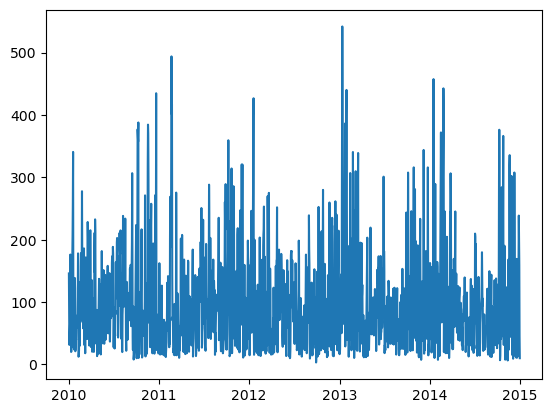

In [4]:
from matplotlib import pyplot as plt
plt.plot(air_pollution.pollution_today)
plt.show()

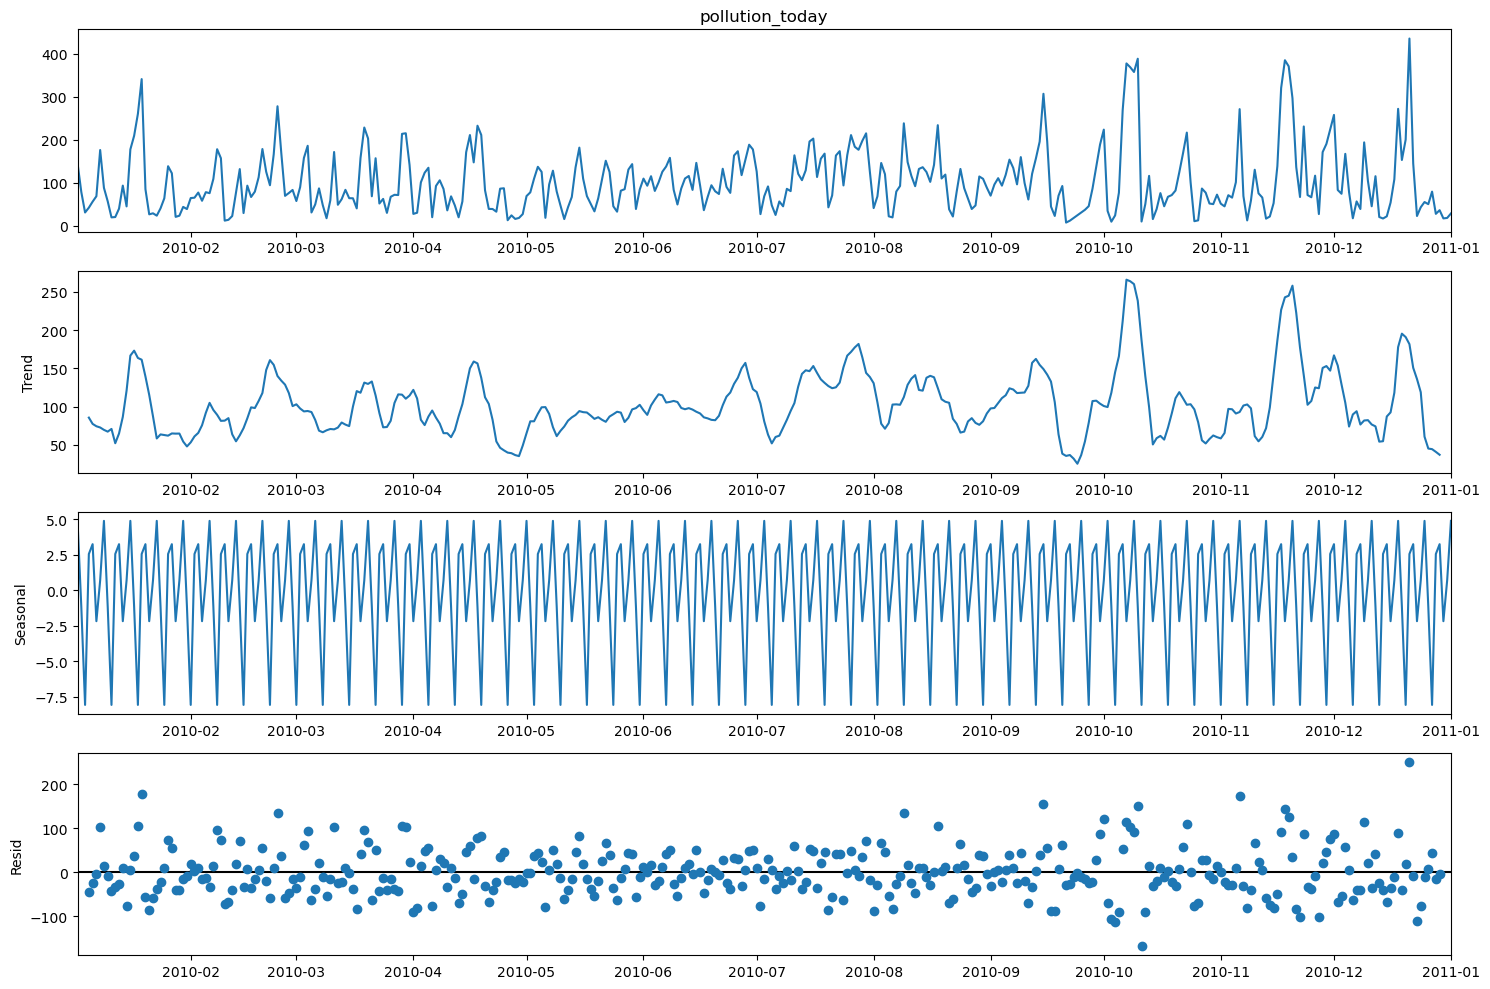

In [5]:
from statsmodels.tsa.seasonal import seasonal_decompose
from pylab import rcParams
series = air_pollution.pollution_today[:365] #처음 1년간의 자료
result = seasonal_decompose(series) #시계열 성분 분해
rcParams['figure.figsize'] = 15, 10
result.plot()
plt.show()

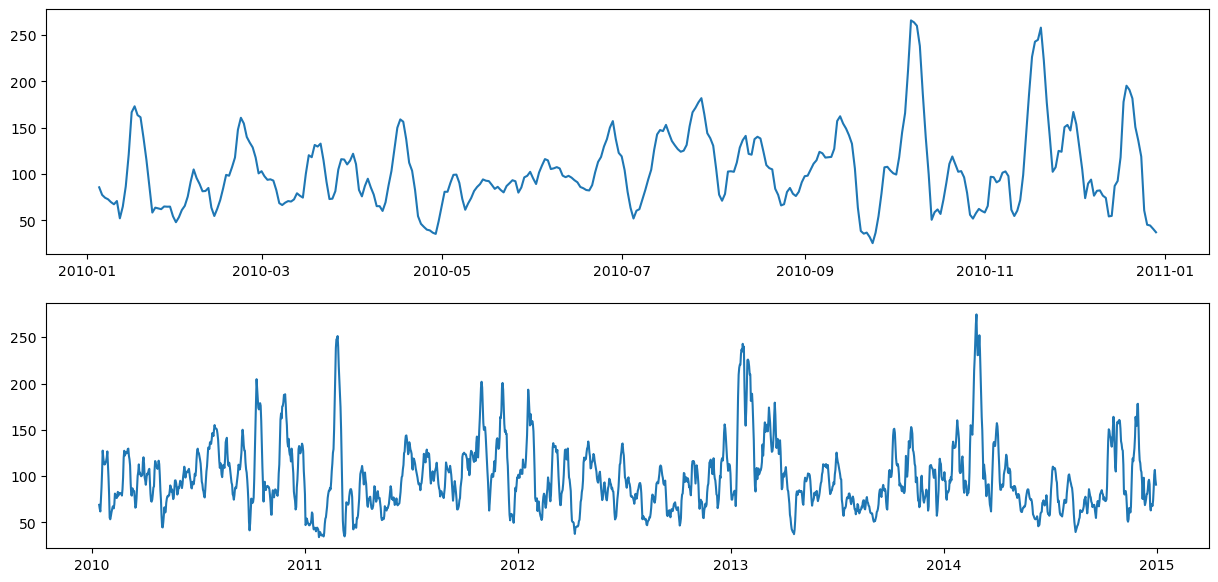

In [6]:
fig = plt.figure(figsize=(15, 7))
layout = (2, 2)
pm_ax = plt.subplot2grid(layout, (0, 0), colspan=2)
mv_ax = plt.subplot2grid(layout, (1, 0), colspan=2)
pm_ax.plot(result.trend) #전체 기간
mm = air_pollution.pollution_today.rolling(12).mean() #이동평균(12일간)
mv_ax.plot(mm)

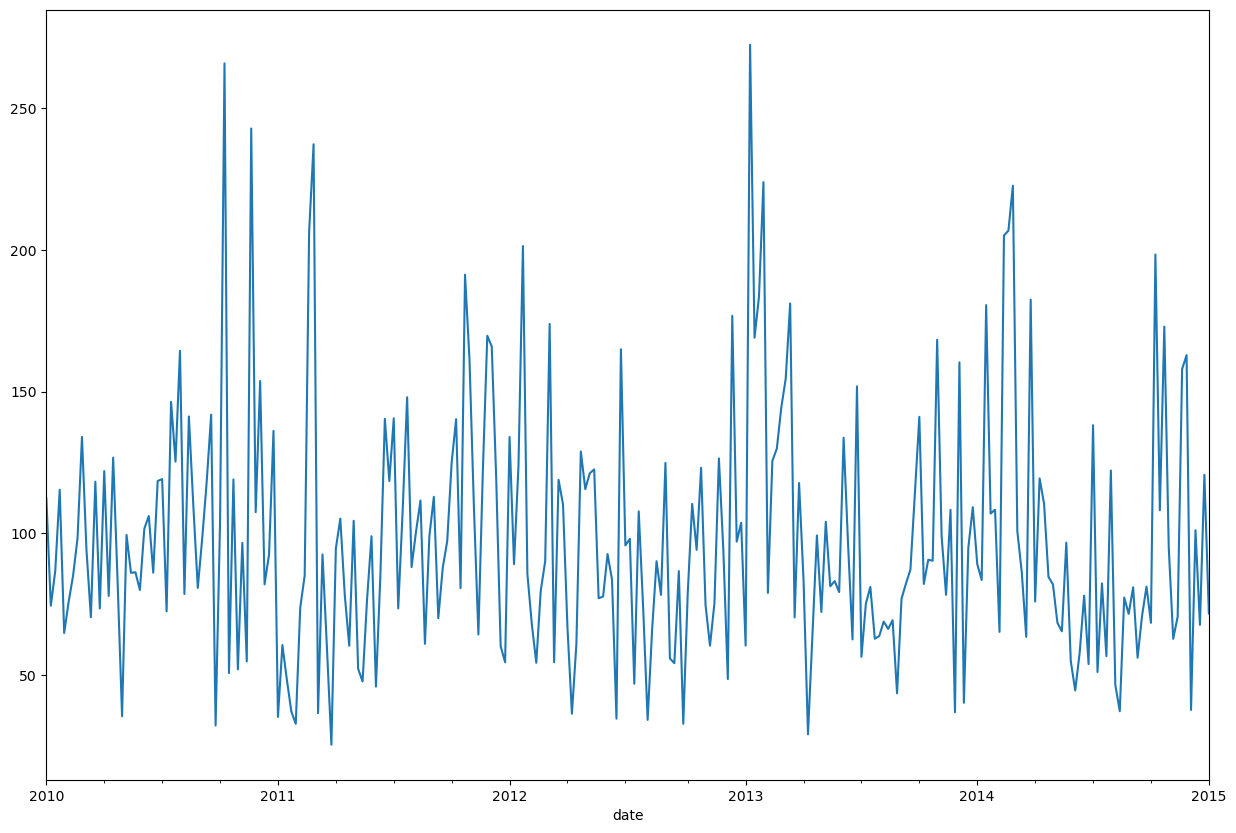

In [7]:
resample = air_pollution.resample('W') #시계열데이터를 주단위로 리샘플링
weekly_mean = resample.mean()
weekly_mean.pollution_today.plot()
plt.show()

In [8]:
from statsmodels.tsa.stattools import adfuller
X = air_pollution.pollution_today.values
result = adfuller(X)
print('p-value: %f' % result[1])

p-value: 0.000000


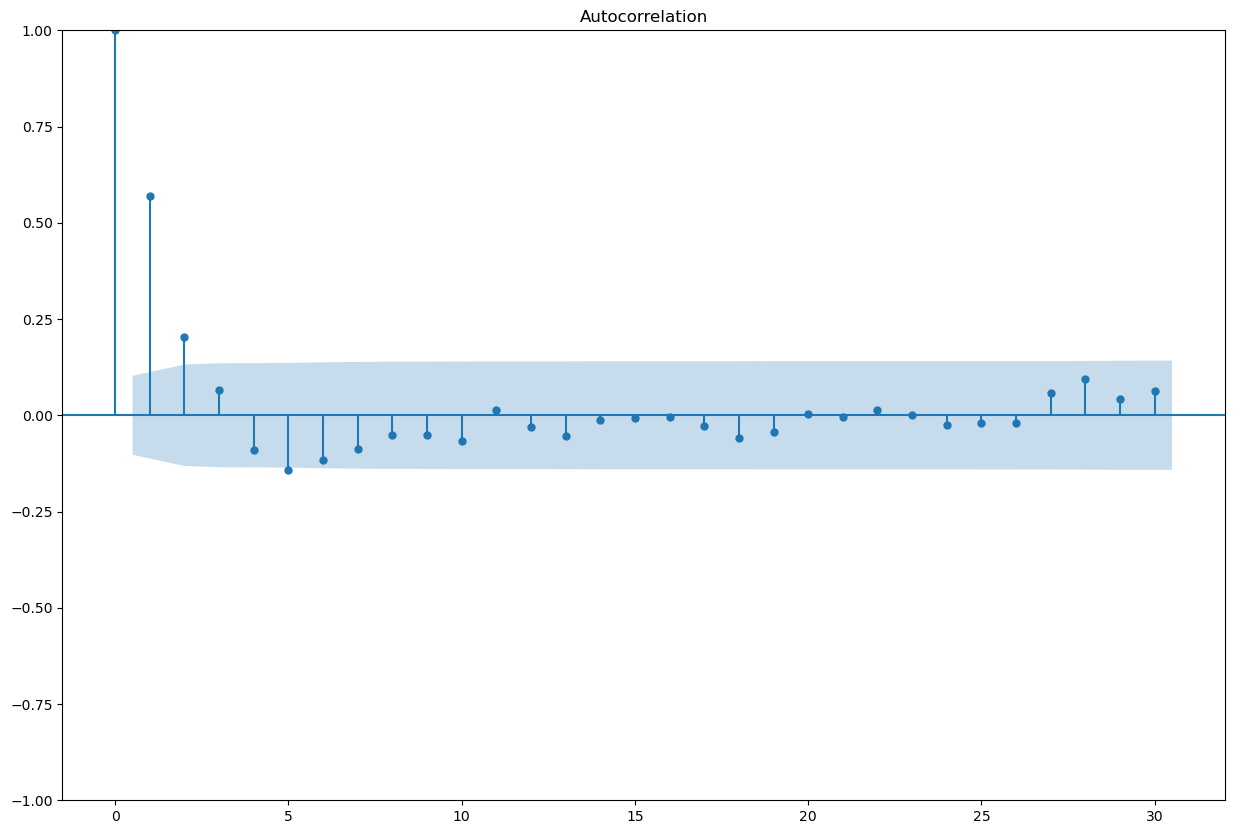

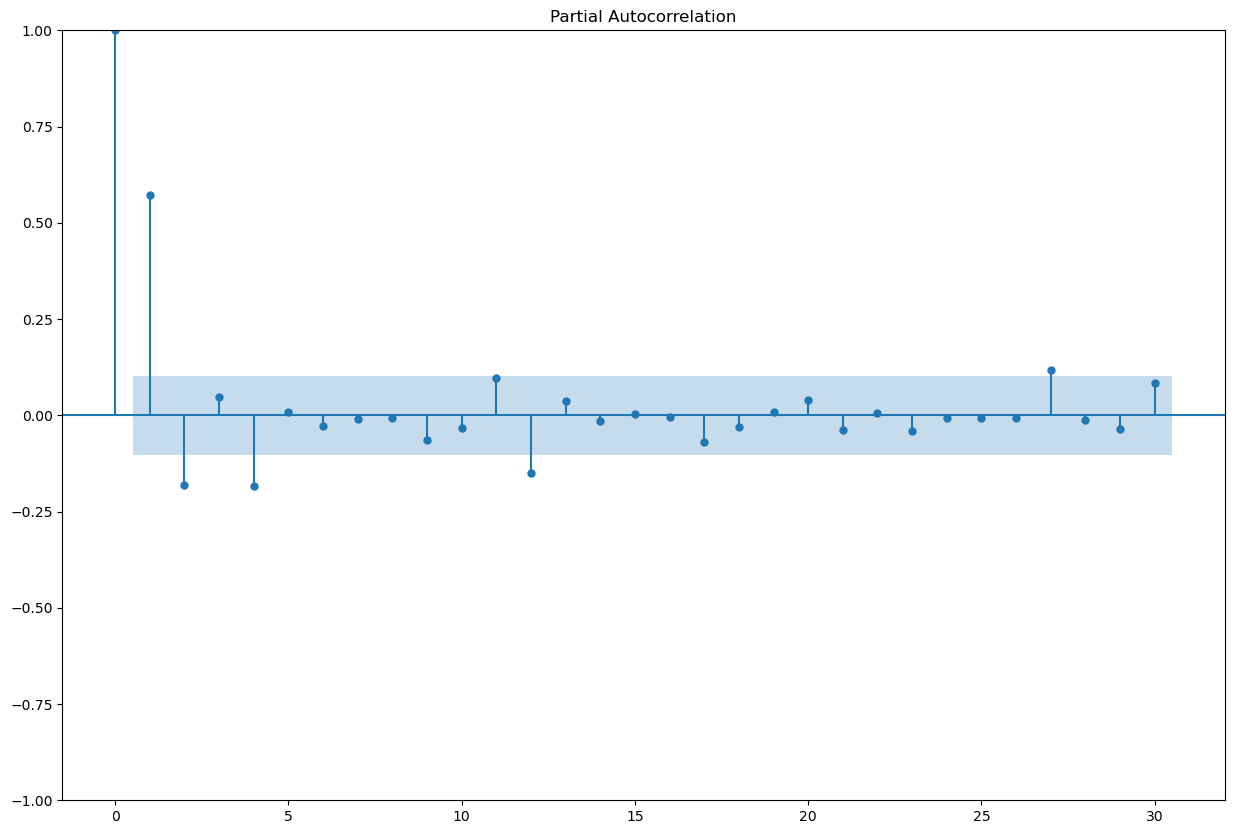

In [9]:
from statsmodels.graphics.tsaplots import plot_acf, plot_pacf
# acf와 pacf를 통해 적합한 arima 모형 결정
# acf(자기상관함수), pacf(부분자기상관함수) , lag 시차
# lag 0 시점은 읽지 않음
# lag 3부터 점선 안에 존재함 lag 절단값은 3 => MA(3)
plot_acf(series, lags=30)
plot_pacf(series, lags=30)
# 절단값이 명확하지 않아 AR 모형 확정이 어려운 상태
plt.show()

In [10]:
resultsDict = {}
predictionsDict = {}
split_date = '2014-01-01'
df_training = air_pollution.loc[air_pollution.index <= split_date]
df_test = air_pollution.loc[air_pollution.index > split_date]
print(len(df_training))
print(len(df_test))

1461
364


In [11]:
import pmdarima as pm
autoModel = pm.auto_arima(df_training.pollution_today, error_action='ignore', suppress_warnings=True, seasonal=False)
autoModel.fit(df_training.pollution_today)

ARIMA(order=(0, 0, 3), scoring_args={}, suppress_warnings=True)

In [12]:
from statsmodels.tsa.arima.model import ARIMA
model = ARIMA(df_training.pollution_today, order=(0,0,3)).fit()

c:\anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:471: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  self._init_dates(dates, freq)
c:\anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:471: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  self._init_dates(dates, freq)
c:\anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:471: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  self._init_dates(dates, freq)


In [13]:
import numpy as np
from sklearn.metrics import r2_score
def _error(real, pred):
    return real - pred
def mse(real, pred):
    return np.mean(np.square(_error(real, pred)))
def rmse(real, pred):
    return np.sqrt(mse(real, pred))
def mae(real, pred):
    return np.mean(np.abs(_error(real, pred)))
METRICS = {
    "mse": mse,
    "rmse": rmse,
    "mae": mae,
    "r2": r2_score,
}
def evaluate(real, pred, metrics=("mse", "rmse", "mae", "r2")):
    results = {}
    for name in metrics:
        try:
            results[name] = METRICS[name](real, pred)
        except:
            results[name] = np.nan
    return results

In [14]:
from tqdm import tqdm
#시간이 오래걸림
index = len(df_training)
yhat = list()
for t in tqdm(range(len(df_test.pollution_today))):
    temp_train = air_pollution[:len(df_training)+t]
    model = ARIMA(temp_train.pollution_today, order=(0, 0, 3))
    model_fit = model.fit()
    predictions = model_fit.predict(start=len(temp_train), end=len(temp_train), dynamic=False)
    yhat = yhat + [predictions]
yhat = pd.concat(yhat)
resultsDict['ARIMA'] = evaluate(df_test.pollution_today,
yhat.values)
predictionsDict['ARIMA'] = yhat.values

  0%|          | 0/364 [00:00<?, ?it/s]c:\anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:471: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  self._init_dates(dates, freq)
c:\anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:471: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  self._init_dates(dates, freq)
c:\anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:471: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  self._init_dates(dates, freq)
  0%|          | 1/364 [00:00<00:56,  6.47it/s]c:\anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:471: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  self._init_dates(dates, freq)
c:\anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:471: ValueWarning: No frequency information was provided, so inferred frequen

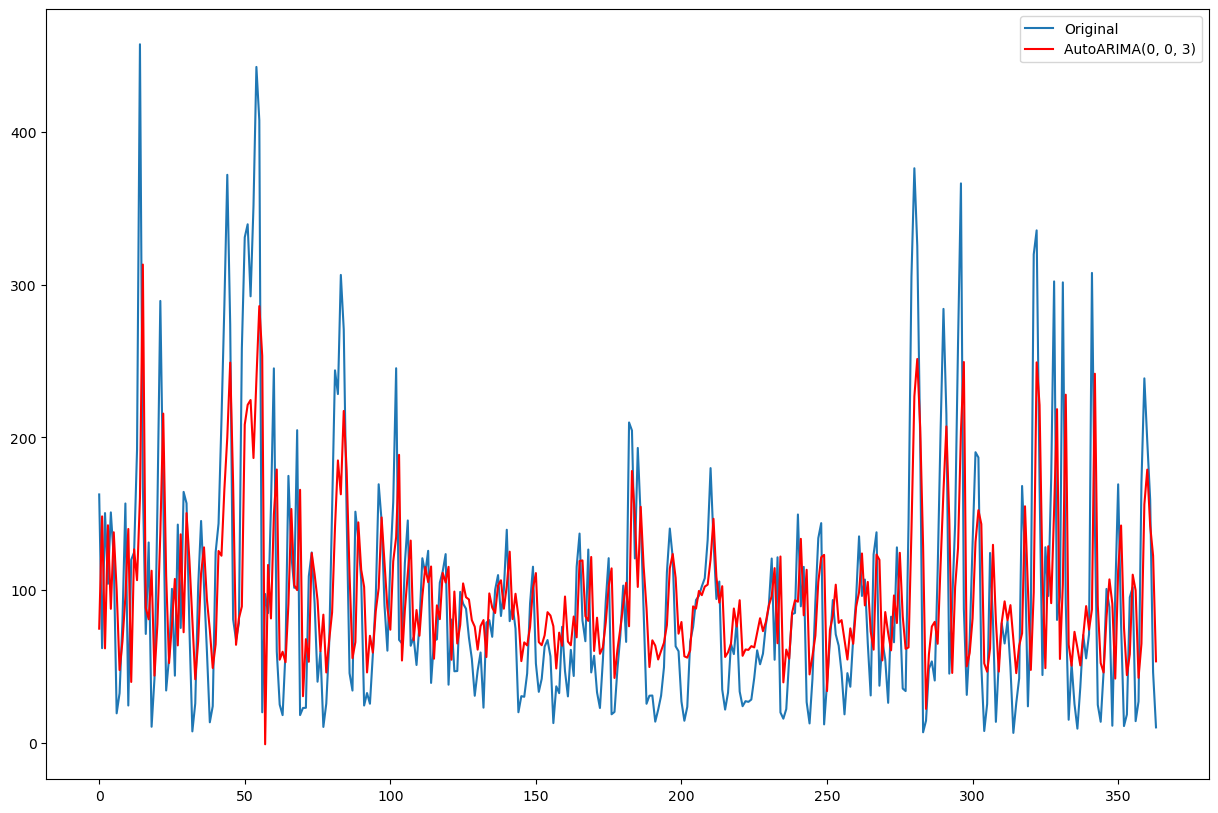

In [15]:
order = autoModel.order
plt.plot(df_test.pollution_today.values, label='Original')
plt.plot(yhat.values, color='red', label='AutoARIMA{0}'.format(order))
plt.legend()
plt.show()

In [16]:
def create_time_features(df, target=None):
    df['date'] = df.index
    df['hour'] = df['date'].dt.hour
    df['dayofweek'] = df['date'].dt.dayofweek
    df['quarter'] = df['date'].dt.quarter
    df['month'] = df['date'].dt.month
    df['year'] = df['date'].dt.year
    df['dayofyear'] = df['date'].dt.dayofyear
    df['sin_day'] = np.sin(df['dayofyear'])
    df['cos_day'] = np.cos(df['dayofyear'])
    df['dayofmonth'] = df['date'].dt.day
    df['weekofyear'] = df['date'].dt.weekofyear
    X = df.drop(['date'], axis=1)
    if target:
        y = df[target]
        X = X.drop([target], axis=1)
        return X, y
    return X

In [17]:
from sklearn.preprocessing import StandardScaler
X_train_df, y_train = create_time_features(df_training, target='pollution_today')
X_test_df, y_test = create_time_features(df_test, target='pollution_today')
scaler = StandardScaler()
scaler.fit(X_train_df)
X_train = scaler.transform(X_train_df)
X_test = scaler.transform(X_test_df)
X_train_df = pd.DataFrame(X_train, columns=X_train_df.columns)
X_test_df = pd.DataFrame(X_test, columns=X_test_df.columns)

In [18]:
from sklearn.linear_model import LinearRegression
reg = LinearRegression()
reg.fit(X_train, y_train)
yhat = reg.predict(X_test)
resultsDict['LinearRegression'] = evaluate(df_test.pollution_today, yhat)
predictionsDict['LinearRegression'] = yhat

In [19]:
from sklearn.ensemble import RandomForestRegressor
reg = RandomForestRegressor(max_depth=2, random_state=0)
reg.fit(X_train, y_train)
yhat = reg.predict(X_test)
resultsDict['RF'] = evaluate(df_test.pollution_today, yhat)
predictionsDict['RF'] = yhat

In [20]:
from xgboost import XGBRegressor
reg = XGBRegressor(objective='reg:squarederror', n_estimators=1000)
reg.fit(X_train, y_train,verbose=False)
yhat = reg.predict(X_test)
resultsDict['XGBoost'] = evaluate(df_test.pollution_today, yhat)
predictionsDict['XGBoost'] = yhat

In [21]:
from lightgbm import LGBMRegressor
lightGBM = LGBMRegressor()
lightGBM.fit(X_train, y_train)
yhat = lightGBM.predict(X_test)
resultsDict['Lightgbm'] = evaluate(df_test.pollution_today, yhat)
predictionsDict['Lightgbm'] = yhat

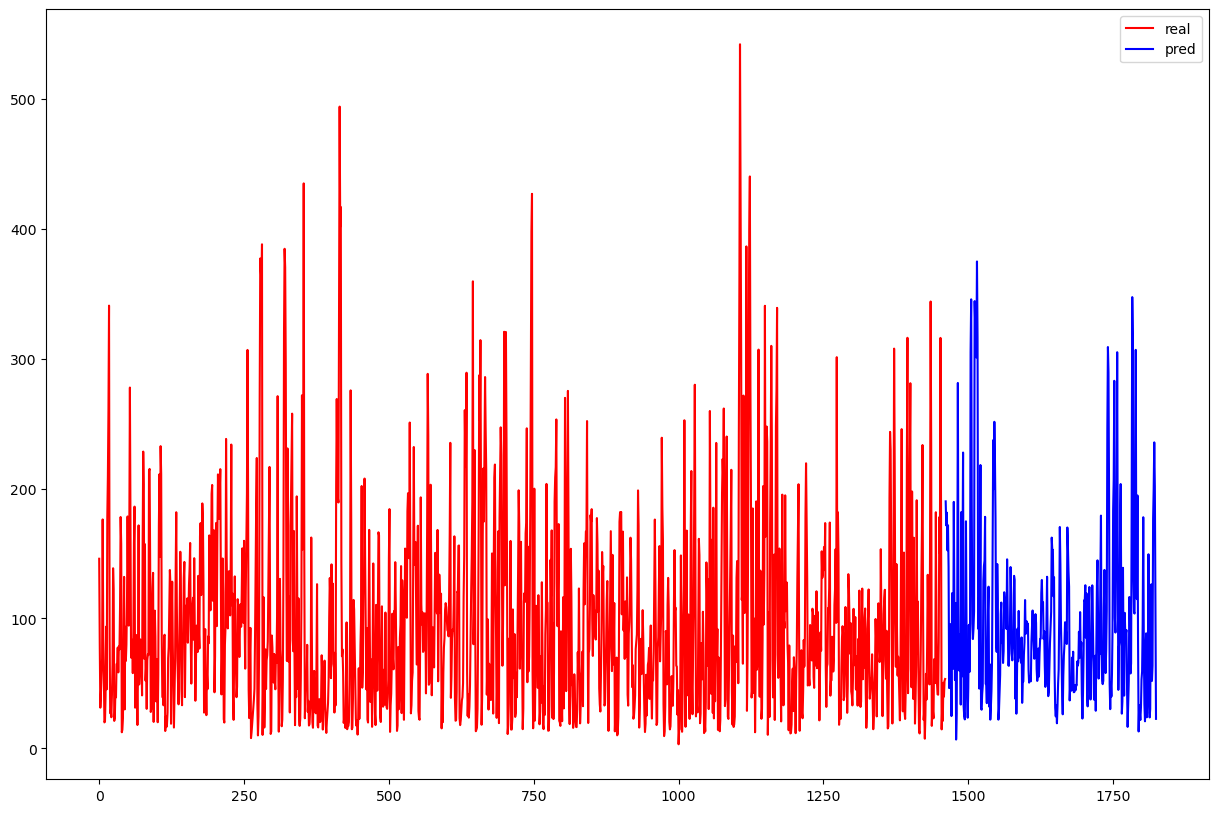

In [22]:
a=np.concatenate((df_training.pollution_today.values, np.zeros(len(X_train))+np.nan))
b=np.concatenate((np.zeros(len(X_train))+np.nan, yhat))
plt.plot(a, 'r-', label='real')
plt.plot(b, 'b-', label='pred')
plt.legend()
plt.show()

In [23]:
from sklearn.svm import SVR
reg = SVR(kernel='rbf', C=100, gamma=0.01)
reg.fit(X_train, y_train)
yhat = reg.predict(X_test)
resultsDict['SVM'] = evaluate(df_test.pollution_today, yhat)
predictionsDict['SVM'] = yhat

In [24]:
from sklearn.neighbors import KNeighborsRegressor
reg = KNeighborsRegressor(n_neighbors=2)
reg.fit(X_train, y_train)
yhat = reg.predict(X_test)
resultsDict['KNN'] = evaluate(df_test.pollution_today, yhat)
predictionsDict['KNN'] = yhat

In [25]:
import tensorflow as tf
tf.random.set_seed(0)
BATCH_SIZE = 64
BUFFER_SIZE = 100
WINDOW_LENGTH = 24
#타임스텝 7로 설정
def window_data(X, Y, window=7):
    x = []
    y = []
    for i in range(window-1, len(X)):
        x.append(X[i-window+1:i+1])
        y.append(Y[i])
    return np.array(x), np.array(y)
X_w = np.concatenate((X_train, X_test))
y_w = np.concatenate((y_train, y_test))
X_w, y_w = window_data(X_w, y_w, window=WINDOW_LENGTH)
X_train_w = X_w[:-len(X_test)]
y_train_w = y_w[:-len(X_test)]
X_test_w = X_w[-len(X_test):]
y_test_w = y_w[-len(X_test):]
train_data = tf.data.Dataset.from_tensor_slices((X_train_w, y_train_w))
train_data = train_data.cache().shuffle(BUFFER_SIZE).batch(BATCH_SIZE).repeat()
val_data = tf.data.Dataset.from_tensor_slices((X_test_w, y_test_w))
val_data = val_data.batch(BATCH_SIZE).repeat()

In [26]:
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import LSTM,Dense
dropout = 0.0
lstm_model = Sequential([
    LSTM(128, input_shape=X_train_w.shape[-2:], dropout=dropout),
    Dense(128),
    Dense(128),
    Dense(1)
])
lstm_model.compile(optimizer='rmsprop', loss='mae')
lstm_model.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 lstm (LSTM)                 (None, 128)               74752     
                                                                 
 dense (Dense)               (None, 128)               16512     
                                                                 
 dense_1 (Dense)             (None, 128)               16512     
                                                                 
 dense_2 (Dense)             (None, 1)                 129       
                                                                 
Total params: 107,905
Trainable params: 107,905
Non-trainable params: 0
_________________________________________________________________


In [27]:
#steps_per_epoch : 훈련 샘플수 / 배치 사이즈
model_history = lstm_model.fit(train_data, epochs=10, steps_per_epoch=200, validation_data=val_data, validation_steps=50)

Epoch 1/10
200/200 [==============================] - 5s 10ms/step - loss: 52.0820 - val_loss: 43.2324
Epoch 2/10
200/200 [==============================] - 1s 7ms/step - loss: 35.7249 - val_loss: 35.6772
Epoch 3/10
200/200 [==============================] - 1s 7ms/step - loss: 29.7430 - val_loss: 30.7960
Epoch 4/10
200/200 [==============================] - 1s 7ms/step - loss: 26.6886 - val_loss: 30.6990
Epoch 5/10
200/200 [==============================] - 1s 7ms/step - loss: 24.1476 - val_loss: 31.5405
Epoch 6/10
200/200 [==============================] - 1s 7ms/step - loss: 21.8547 - val_loss: 30.2307
Epoch 7/10
200/200 [==============================] - 1s 7ms/step - loss: 19.6244 - val_loss: 32.1799
Epoch 8/10
200/200 [==============================] - 1s 7ms/step - loss: 17.8799 - val_loss: 32.1758
Epoch 9/10
200/200 [==============================] - 1s 7ms/step - loss: 16.1163 - val_loss: 32.8532
Epoch 10/10
200/200 [==============================] - 2s 8ms/step - loss: 14.660

In [28]:
yhat = lstm_model.predict(X_test_w).reshape(1, -1)[0]
resultsDict['LSTM'] = evaluate(y_test, yhat)
predictionsDict['LSTM'] = yhat

12/12 [==============================] - 0s 2ms/step


In [29]:
def bar_metrics(resultsDict):
    df = pd.DataFrame.from_dict(resultsDict)
    colors = plt.rcParams["axes.prop_cycle"].by_key()["color"]
    pallette = plt.cm.get_cmap("tab20c", len(df.columns))
    colors = [pallette(x) for x in range(len(df.columns))]
    color_dict = dict(zip(df.columns, colors))
    fig = plt.figure(figsize=(20, 15))
    fields=['mae','mse','rmse','r2']
    for idx,field in enumerate(fields):
        fig.add_subplot(2, 2, idx+1)
        plt.title(field.upper())
        df.loc[field].sort_values().plot(
            kind="bar",
            colormap="Paired",
            color=[color_dict.get(x, "#333333") for x in
            df.loc[field].sort_values().index],
        )
        plt.legend()

    plt.tight_layout()
    plt.show()

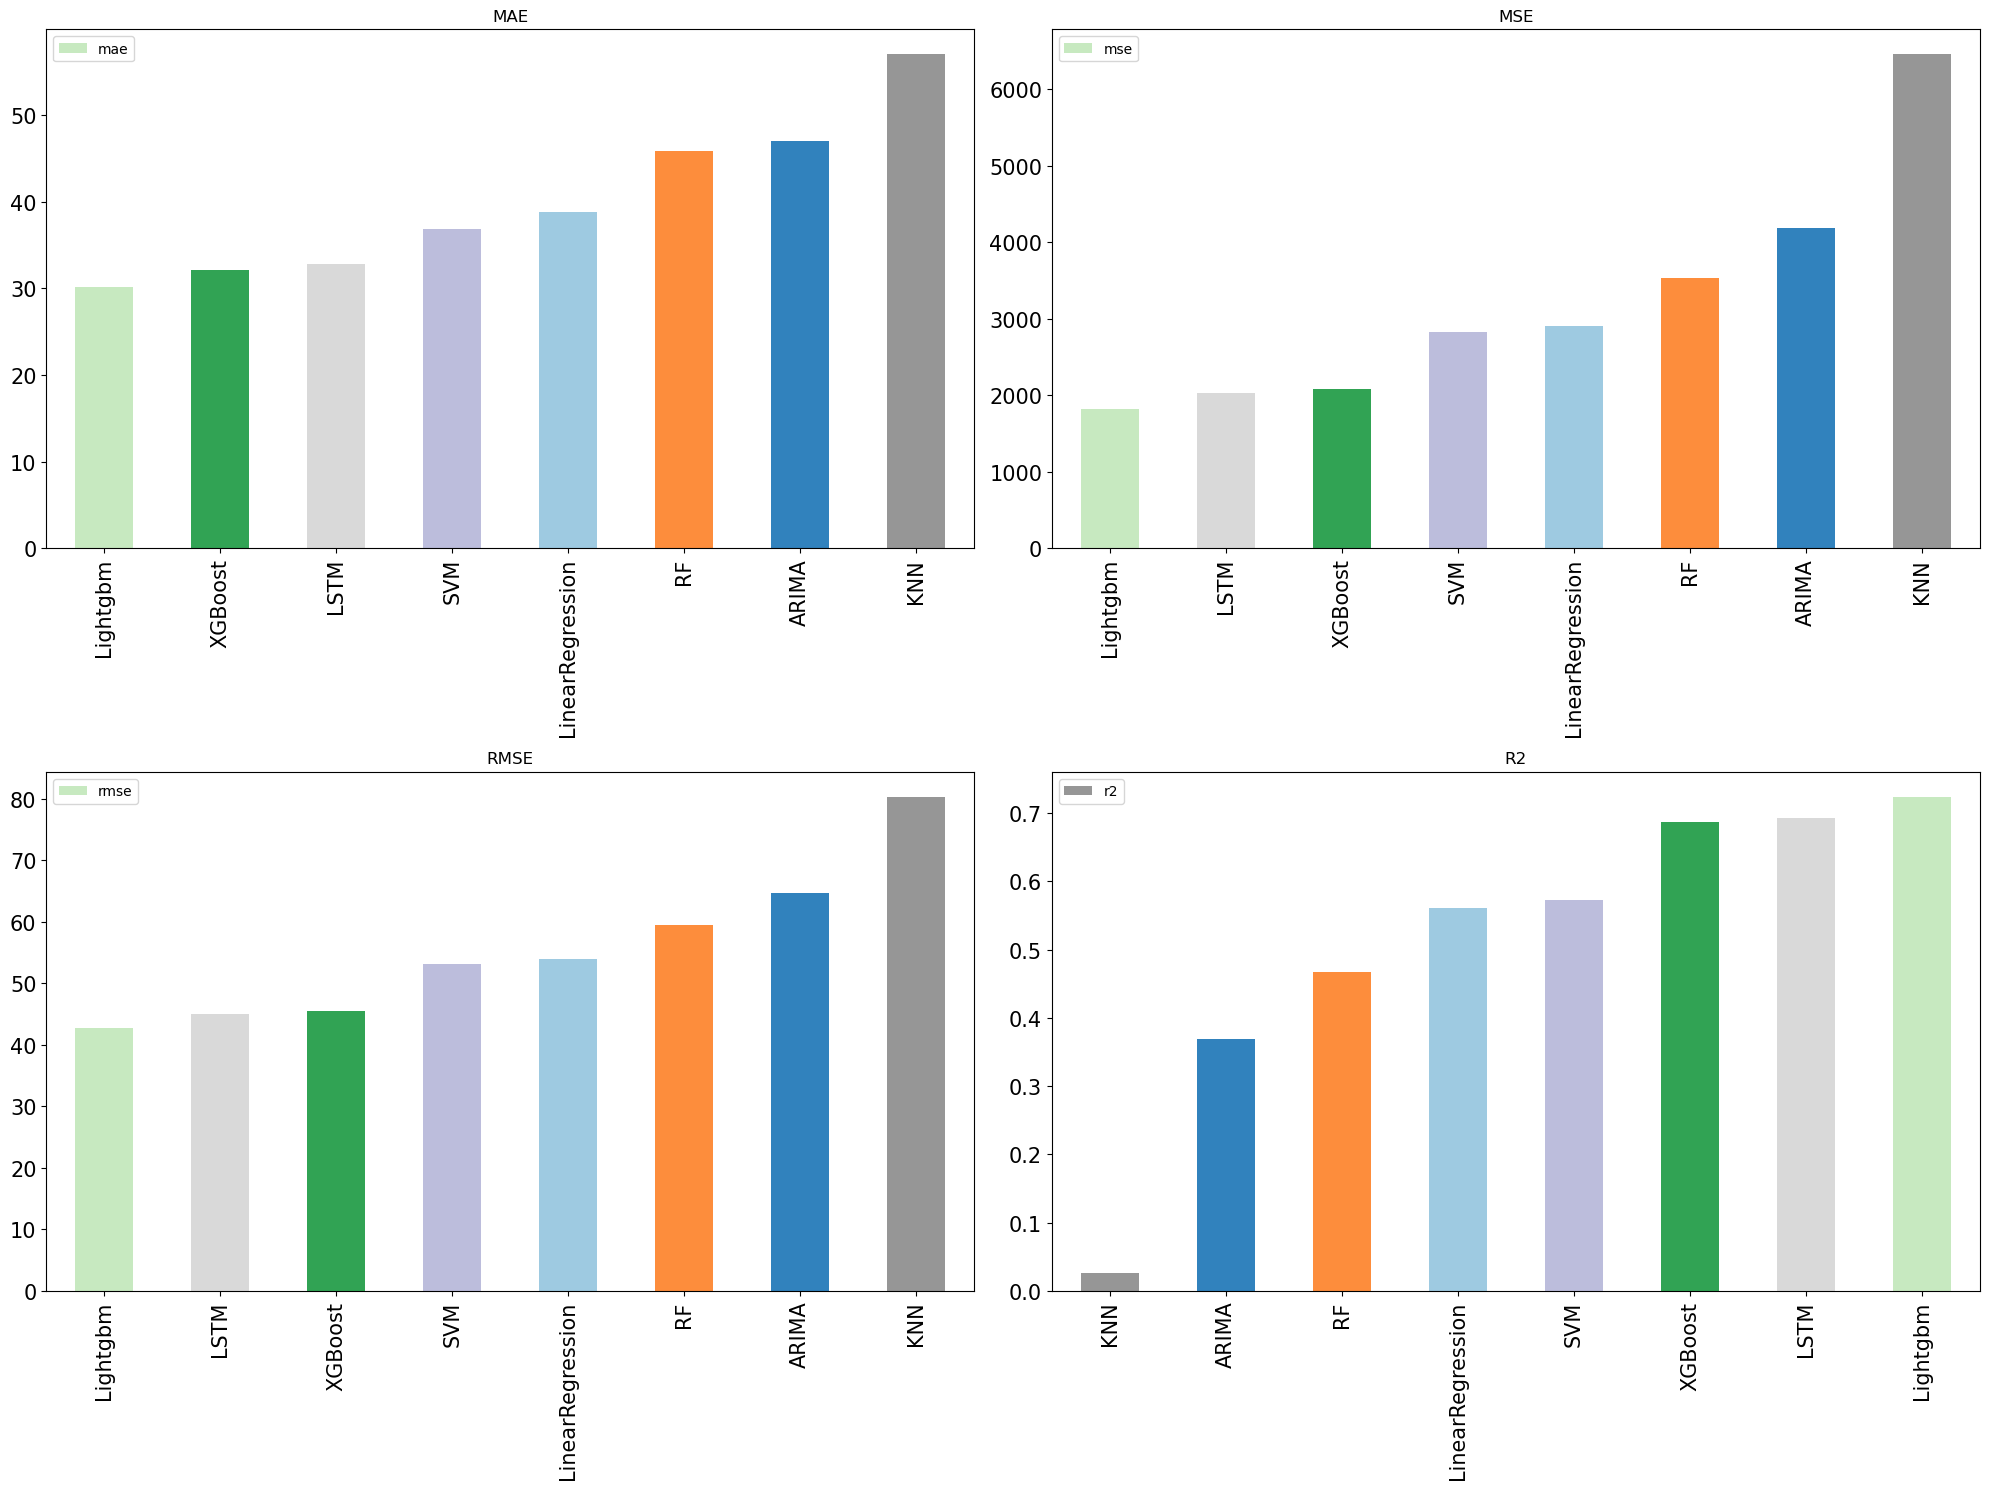

In [30]:
rcParams['xtick.labelsize'] = 15
rcParams['ytick.labelsize'] = 15
bar_metrics(resultsDict)

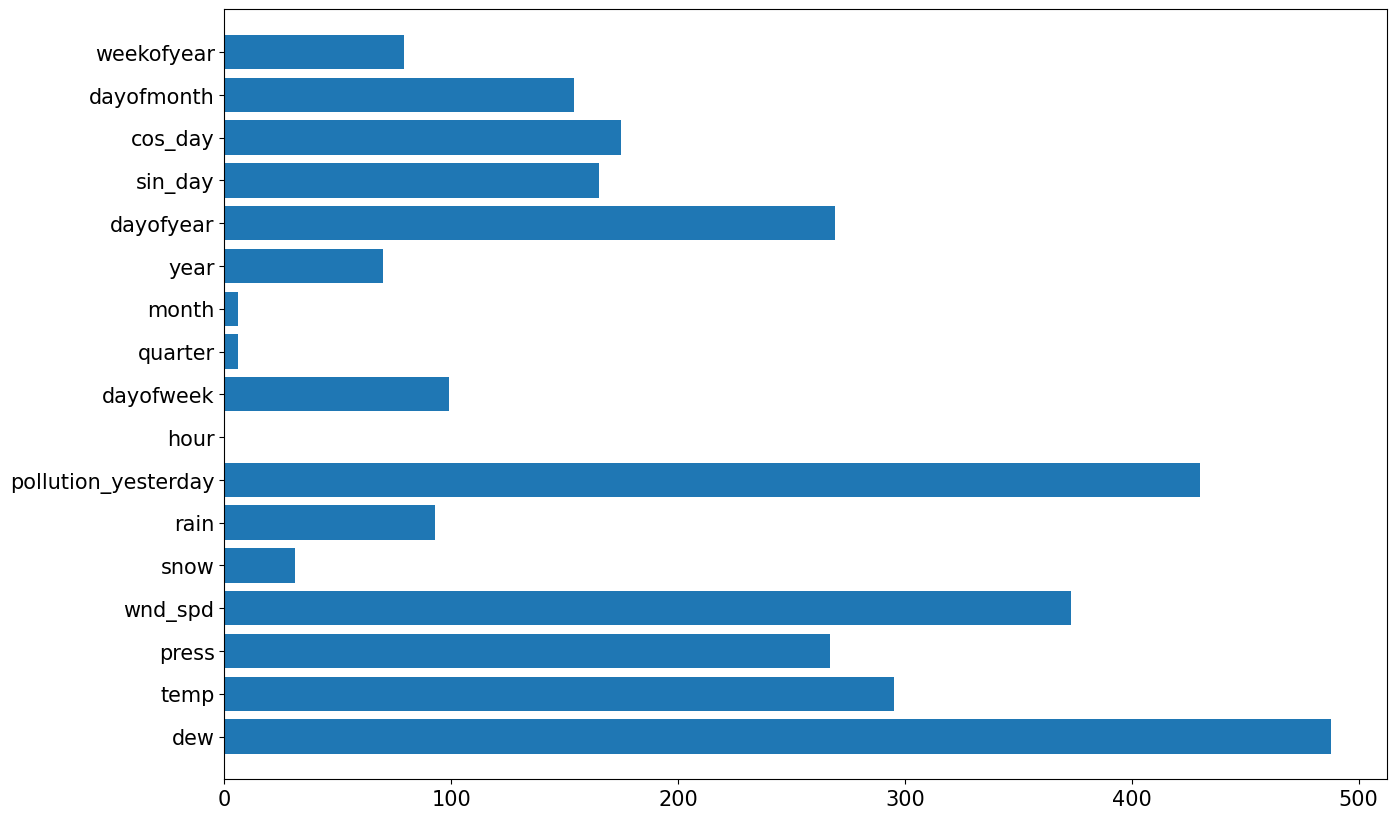

In [31]:
def plot_tree(model):
    n_features =X_train_df.shape[1]
    plt.barh(range(n_features), model.feature_importances_, align='center')
    plt.yticks(np.arange(n_features), X_train_df.columns)
    plt.ylim(-1, n_features)
#특성 중요도
plot_tree(lightGBM)

In [32]:
df = pd.DataFrame.from_dict(resultsDict).transpose().iloc[::-1]
df = df.round(2)
df

,mse,rmse,mae,r2
LSTM,2033.71,45.10,32.80,0.69
KNN,6462.12,80.39,57.05,0.03
SVM,2830.18,53.20,36.85,0.57
Lightgbm,1828.21,42.76,30.21,0.72
XGBoost,2078.24,45.59,32.13,0.69
RF,3534.18,59.45,45.84,0.47
LinearRegression,2909.35,53.94,38.79,0.56
ARIMA,4187.78,64.71,47.01,0.37


<BarContainer object of 8 artists>

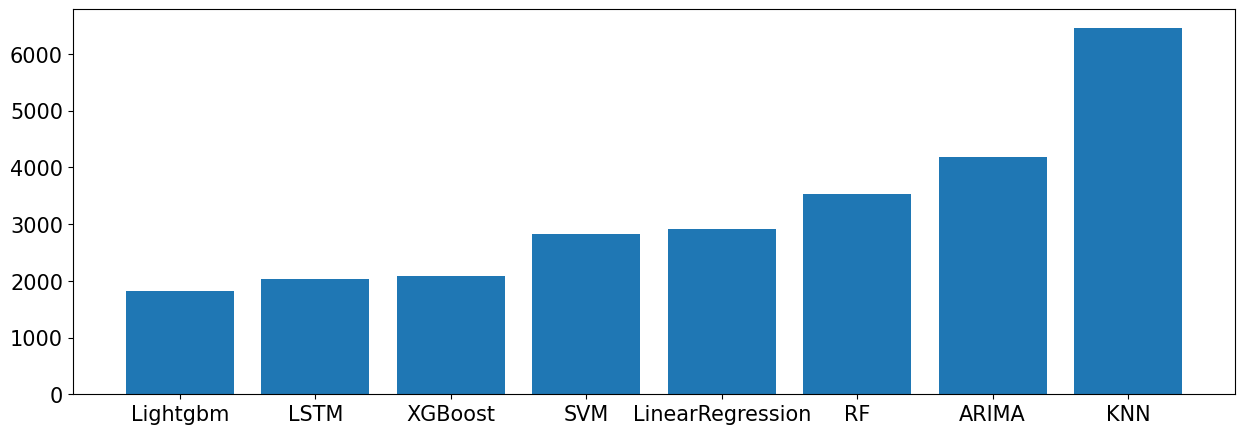

In [33]:
rcParams['figure.figsize'] = 15, 5
df_mse=df.sort_values(by='mse')
plt.bar(df_mse.index, df_mse.mse)

<BarContainer object of 8 artists>

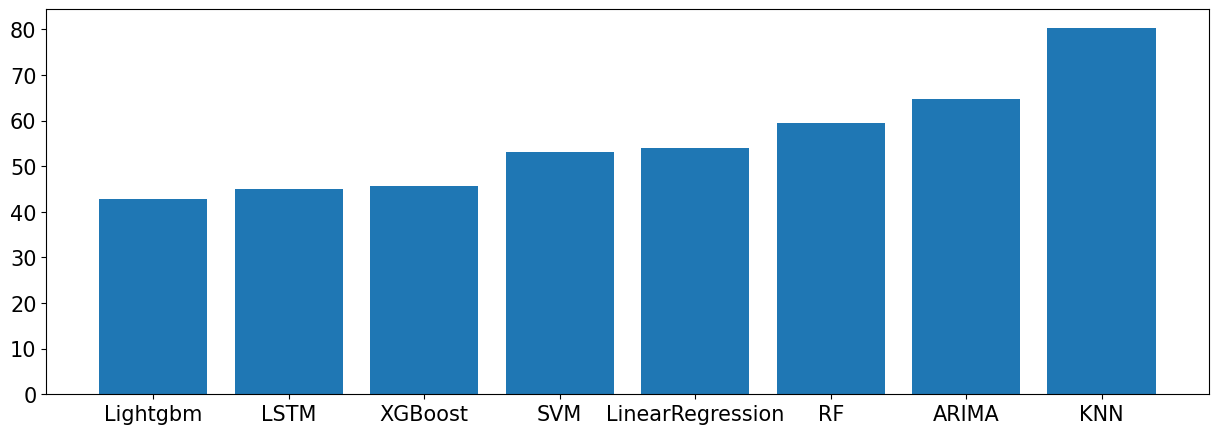

In [34]:
df_rmse=df.sort_values(by='rmse')
plt.bar(df_rmse.index, df_rmse.rmse)

<BarContainer object of 8 artists>

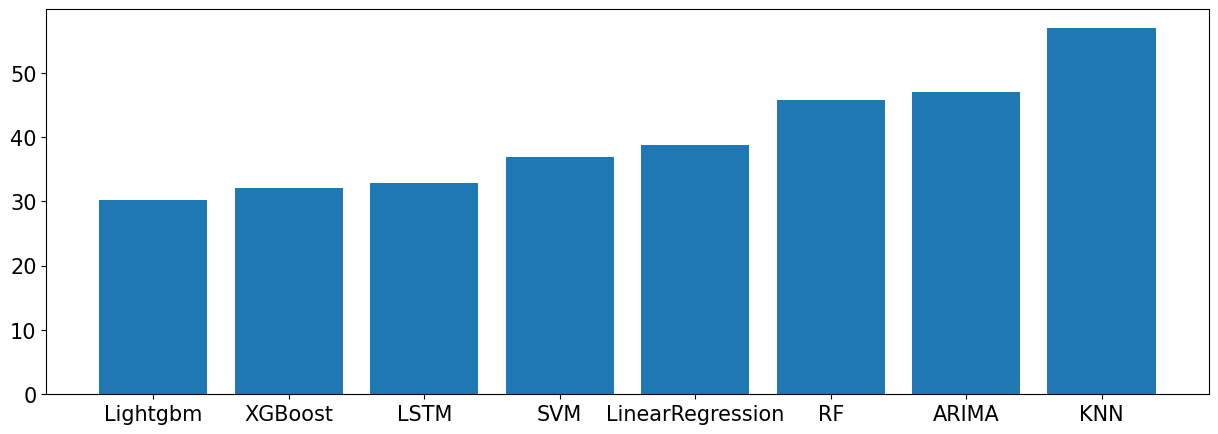

In [35]:
df_mae=df.sort_values(by='mae')
plt.bar(df_mae.index, df_mae.mae)

<BarContainer object of 8 artists>

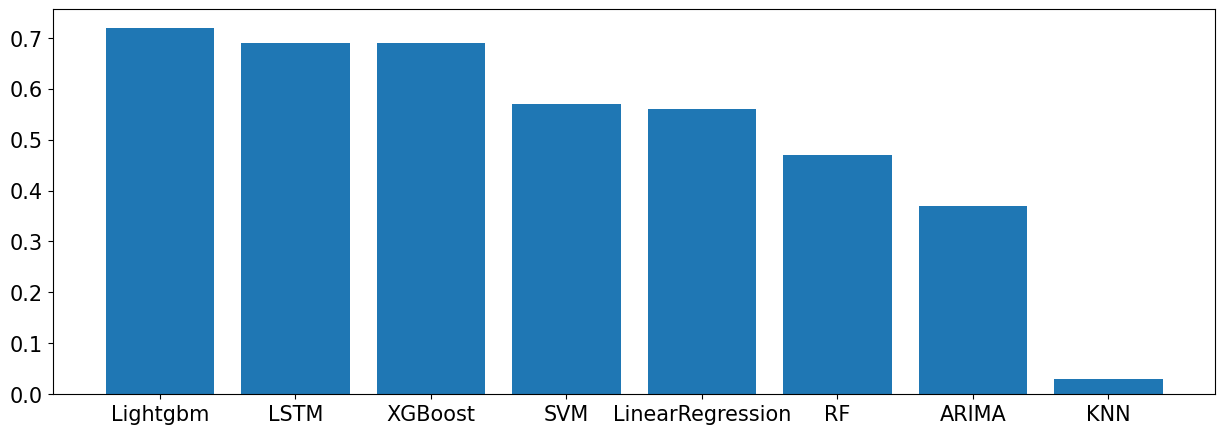

In [36]:
df_r2=df.sort_values(by='r2', ascending=False)
plt.bar(df_r2.index, df_r2.r2)